# Análise Espectroscópica Focada em MLPR

Este notebook segue as melhores práticas da literatura para análise espectroscópica robusta, incluindo:
- Divisão dos dados por Kennard-Stone (70-30)
- Remoção de outliers espectrais (PCA, T²/Q)
- Remoção de outliers dos atributos (boxplot + seaborn)
- Teste de todos os filtros (dependentes e independentes de y)
- Seleção dos 2 melhores filtros por atributo
- Modelagem focada em MLPR (Multi-Layer Perceptron Regressor)
- Plotagens robustas e salvamento de métricas

**Referências principais:**
- Brereton, R. G. (2003). Chemometrics: Data analysis for the laboratory and chemical plant. Wiley.
- Cozzolino, D. (2021). An overview of the use of chemometrics in NIR spectroscopy.
- Rinnan, Å., van den Berg, F., & Engelsen, S. B. (2009). Review of the most common pre-processing techniques for near-infrared spectra. TrAC Trends in Analytical Chemistry, 28(10), 1201-1222.

In [25]:
# Imports necessários
import os
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter, detrend
import warnings
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

# Configurações de plot
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Carregamento dos Dados

In [15]:
# Função para carregar dados
def load_data(filepath):
    """Carrega dados espectrais e separa metadados de espectros."""
    df = pd.read_excel(filepath, engine='openpyxl')
    
    # Identificar colunas que são comprimentos de onda (numéricas)
    numeric_cols = []
    for col in df.columns:
        try:
            float(col)
            numeric_cols.append(col)
        except ValueError:
            continue
    
    # Separar metadados e comprimentos de onda
    metadata = df.drop(columns=numeric_cols)
    wavelengths = df[numeric_cols]
    
    return metadata, wavelengths

# Carregar dados
filepath = 'Data/Original/dataset_cotton_fruit.xlsx'
metadata, wavelengths = load_data(filepath)
X = wavelengths.values
wavelength_values = wavelengths.columns.astype(float)
atributos = ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']

print(f'Dados carregados: {X.shape[0]} amostras, {X.shape[1]} comprimentos de onda')
print(f'Faixa espectral: {wavelength_values.min():.1f} - {wavelength_values.max():.1f} nm')
print(f'Atributos disponíveis: {list(metadata.columns)}')
print(f'Atributos a analisar: {atributos}')

Dados carregados: 250 amostras, 2151 comprimentos de onda
Faixa espectral: 350.0 - 2500.0 nm
Atributos disponíveis: ['Wavelength', 'SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']
Atributos a analisar: ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']


## 2. Divisão dos Dados com Kennard-Stone (70-30)

In [16]:
def kennard_stone(X, train_size=0.7):
    """Implementa o algoritmo Kennard-Stone para divisão de dados."""
    n_samples = X.shape[0]
    n_train = int(n_samples * train_size)
    
    if n_train < 2:
        raise ValueError("O conjunto de treinamento precisa ter pelo menos duas amostras!")
    
    # Calcula as distâncias entre cada par de pontos
    distances = cdist(X, X, metric='euclidean')
    
    # Primeiro ponto: aquele mais distante da média
    mean_sample = np.mean(X, axis=0)
    first_sample = np.argmax(np.linalg.norm(X - mean_sample, axis=1))
    selected = [first_sample]
    
    for _ in range(1, n_train):
        # Calcula a menor distância de cada ponto ao conjunto já selecionado
        min_distances = np.min(distances[selected], axis=0)
        min_distances[selected] = -np.inf  # Evita escolher um ponto já selecionado
        next_sample = np.argmax(min_distances)  # Escolhe o mais distante
        selected.append(next_sample)
    
    return np.array(selected)

# Divisão para cada atributo
dados_divididos = {}

for atributo in atributos:
    y = metadata[atributo].values
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    
    # Padronizar dados para Kennard-Stone
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # Aplicar Kennard-Stone
    idx_cal = kennard_stone(X_scaled, train_size=0.7)
    idx_val = np.setdiff1d(np.arange(X_clean.shape[0]), idx_cal)
    
    X_cal, X_val = X_clean[idx_cal], X_clean[idx_val]
    y_cal, y_val = y_clean[idx_cal], y_clean[idx_val]
    
    dados_divididos[atributo] = {
        'X_cal': X_cal, 'X_val': X_val,
        'y_cal': y_cal, 'y_val': y_val
    }
    
    print(f'{atributo}: {X_cal.shape[0]} calibração, {X_val.shape[0]} validação')

print(f'\nDivisão Kennard-Stone concluída para {len(atributos)} atributos!')

AT: 175 calibração, 75 validação
FIRMEZA (N): 175 calibração, 75 validação
PH: 175 calibração, 75 validação
SST: 175 calibração, 75 validação
UBS (%): 175 calibração, 75 validação

Divisão Kennard-Stone concluída para 5 atributos!


## 3. Remoção de Outliers Espectrais (PCA, T²/Q) nos Dados de Calibração

In [17]:
def pca_outlier_removal(X, n_components=10, threshold=3):
    """Remove outliers usando PCA com estatísticas T² e Q."""
    # Padronizar dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calcular estatística T² (Hotelling's T²)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0)) ** 2, axis=1)
    
    # Calcular estatística Q (resíduos)
    X_reconstructed = pca.inverse_transform(X_pca)
    Q = np.sum((X_scaled - X_reconstructed) ** 2, axis=1)
    
    # Definir limites (média + threshold * desvio padrão)
    T2_limit = np.mean(T2) + threshold * np.std(T2)
    Q_limit = np.mean(Q) + threshold * np.std(Q)
    
    # Identificar outliers
    outliers = (T2 > T2_limit) | (Q > Q_limit)
    
    return ~outliers, T2, Q, T2_limit, Q_limit, pca, X_pca, X_scaled

# Remover outliers espectrais dos dados de calibração
dados_pca = {}

for atributo in atributos:
    X_cal = dados_divididos[atributo]['X_cal']
    mask, T2, Q, T2_limit, Q_limit, pca, X_pca, X_scaled = pca_outlier_removal(X_cal)
    
    dados_pca[atributo] = {
        'X_cal': X_cal[mask],
        'y_cal': dados_divididos[atributo]['y_cal'][mask],
        'T2': T2, 'Q': Q, 'T2_limit': T2_limit, 'Q_limit': Q_limit,
        'pca': pca, 'X_pca': X_pca, 'X_scaled': X_scaled, 'mask': mask
    }
    
    print(f'{atributo}: {np.sum(~mask)} outliers espectrais removidos da calibração')
    print(f'  Calibração: {X_cal[mask].shape[0]} amostras')
    print(f'  Validação: {dados_divididos[atributo]["X_val"].shape[0]} amostras')
    print()

AT: 7 outliers espectrais removidos da calibração
  Calibração: 168 amostras
  Validação: 75 amostras

FIRMEZA (N): 7 outliers espectrais removidos da calibração
  Calibração: 168 amostras
  Validação: 75 amostras

PH: 7 outliers espectrais removidos da calibração
  Calibração: 168 amostras
  Validação: 75 amostras

SST: 7 outliers espectrais removidos da calibração
  Calibração: 168 amostras
  Validação: 75 amostras

UBS (%): 7 outliers espectrais removidos da calibração
  Calibração: 168 amostras
  Validação: 75 amostras



### Gráficos de Outliers T² e Q (como em PCA.ipynb)

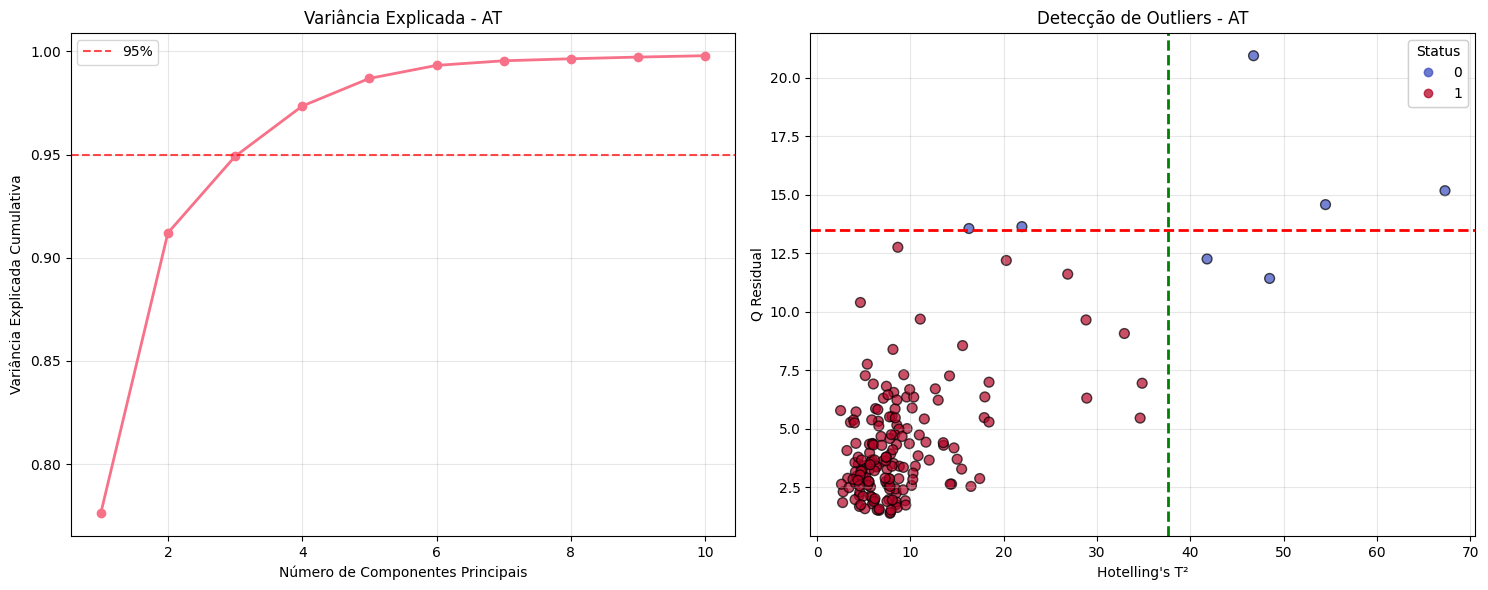

Gráficos de outliers para AT exibidos.



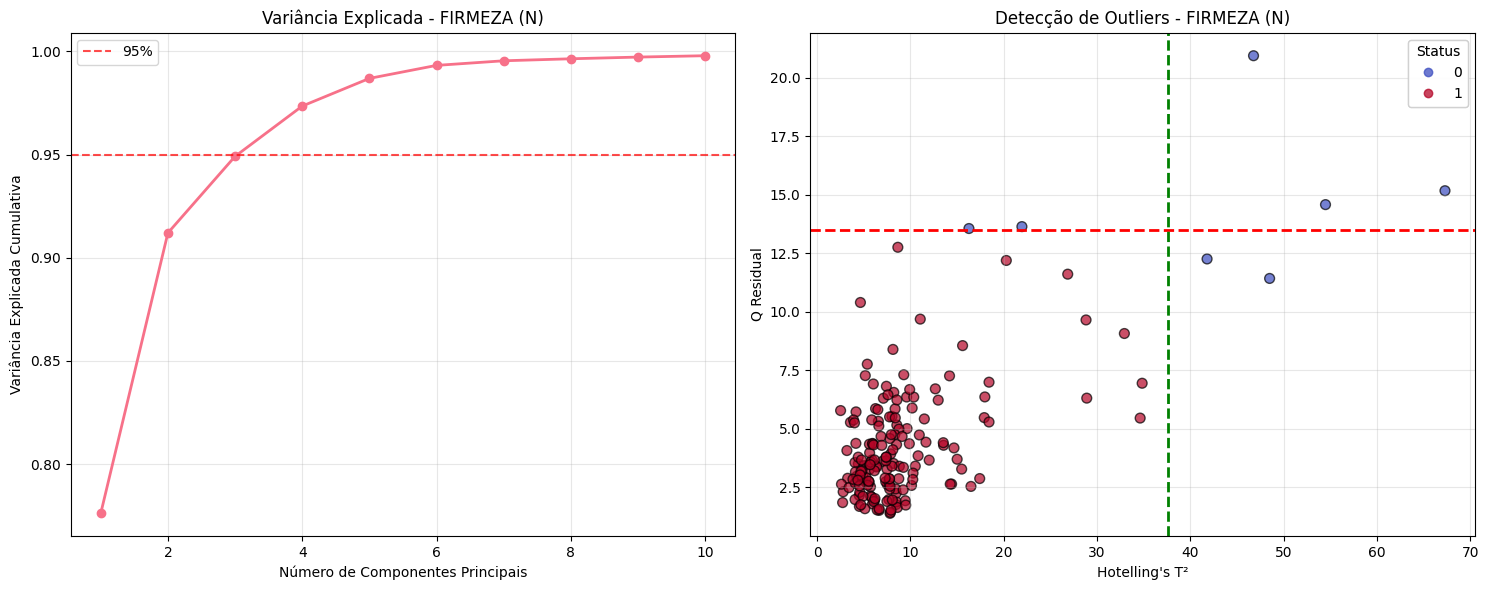

Gráficos de outliers para FIRMEZA (N) exibidos.



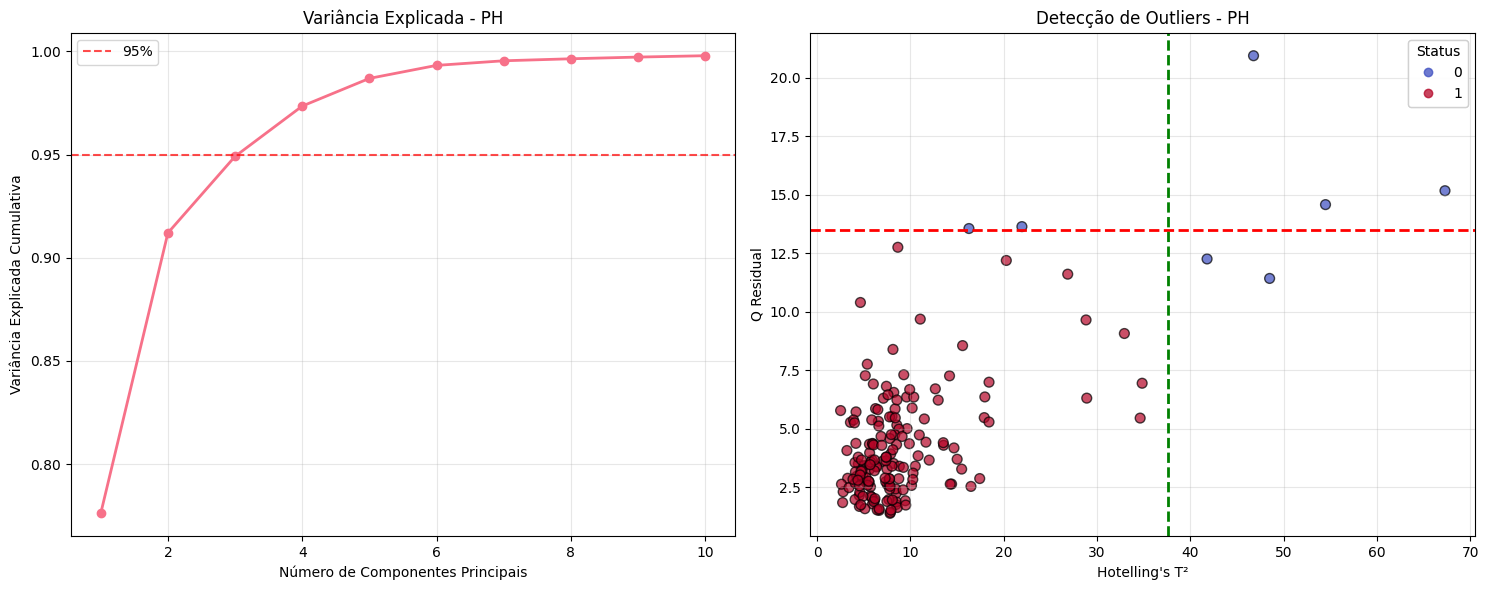

Gráficos de outliers para PH exibidos.



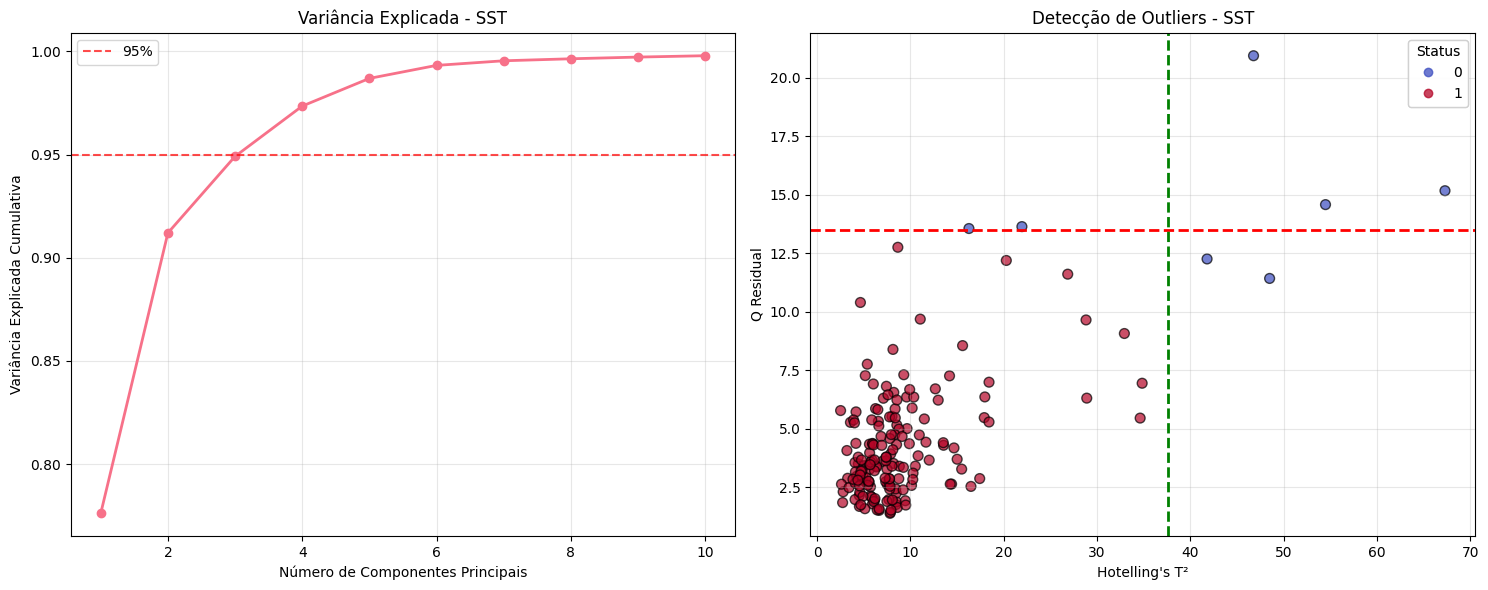

Gráficos de outliers para SST exibidos.



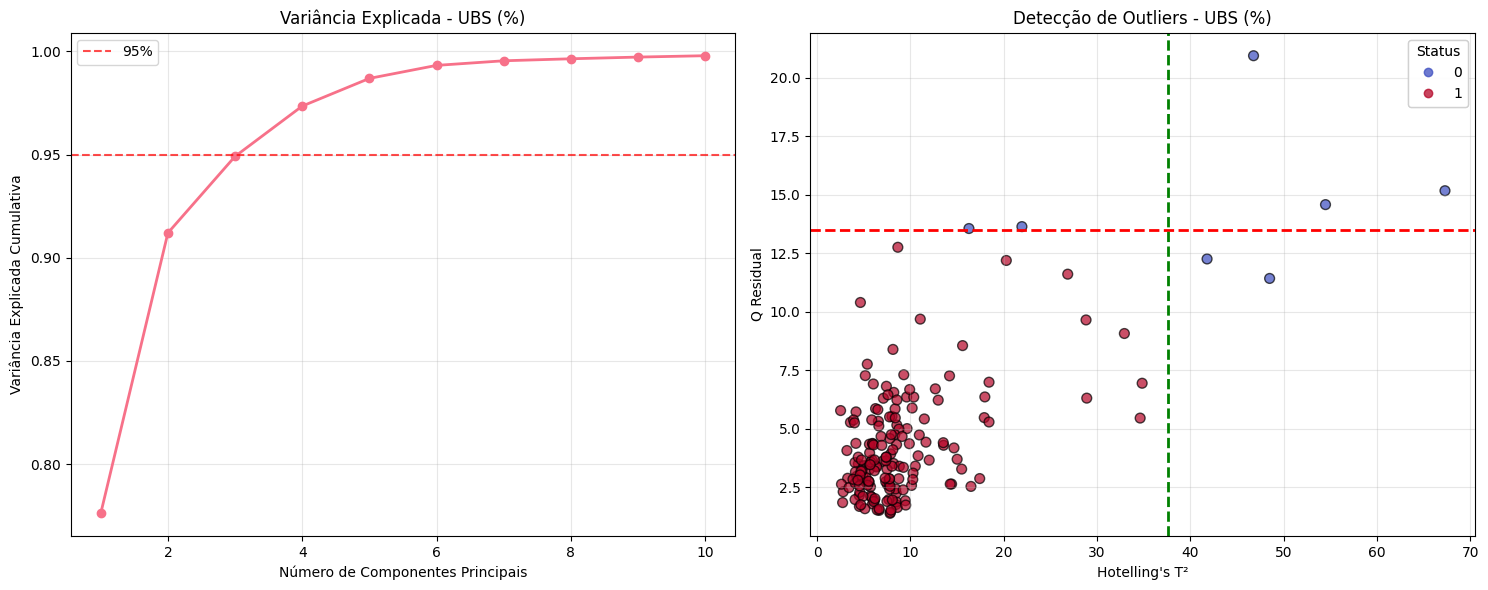

Gráficos de outliers para UBS (%) exibidos.



In [18]:
# Plotar gráficos de outliers T² e Q para cada atributo
for atributo in atributos:
    d = dados_pca[atributo]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Variância explicada cumulativa
    cumulative_variance = np.cumsum(d['pca'].explained_variance_ratio_)
    axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=2, markersize=6)
    axes[0].set_xlabel('Número de Componentes Principais')
    axes[0].set_ylabel('Variância Explicada Cumulativa')
    axes[0].set_title(f'Variância Explicada - {atributo}')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[0].legend()
    
    # Gráfico 2: T² vs Q (detecção de outliers)
    scatter = axes[1].scatter(d['T2'], d['Q'], c=d['mask'], cmap='coolwarm', 
                             edgecolor='k', alpha=0.7, s=50)
    axes[1].axhline(d['Q_limit'], color='r', linestyle='--', linewidth=2, label=f'Q Limit: {d["Q_limit"]:.2f}')
    axes[1].axvline(d['T2_limit'], color='g', linestyle='--', linewidth=2, label=f'T² Limit: {d["T2_limit"]:.2f}')
    axes[1].set_xlabel("Hotelling's T²")
    axes[1].set_ylabel('Q Residual')
    axes[1].set_title(f'Detecção de Outliers - {atributo}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Adicionar legenda de cores
    legend1 = axes[1].legend(*scatter.legend_elements(), title="Status")
    axes[1].add_artist(legend1)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Gráficos de outliers para {atributo} exibidos.')
    print()

## 4. Remoção de Outliers dos Atributos (Boxplot + Seaborn)

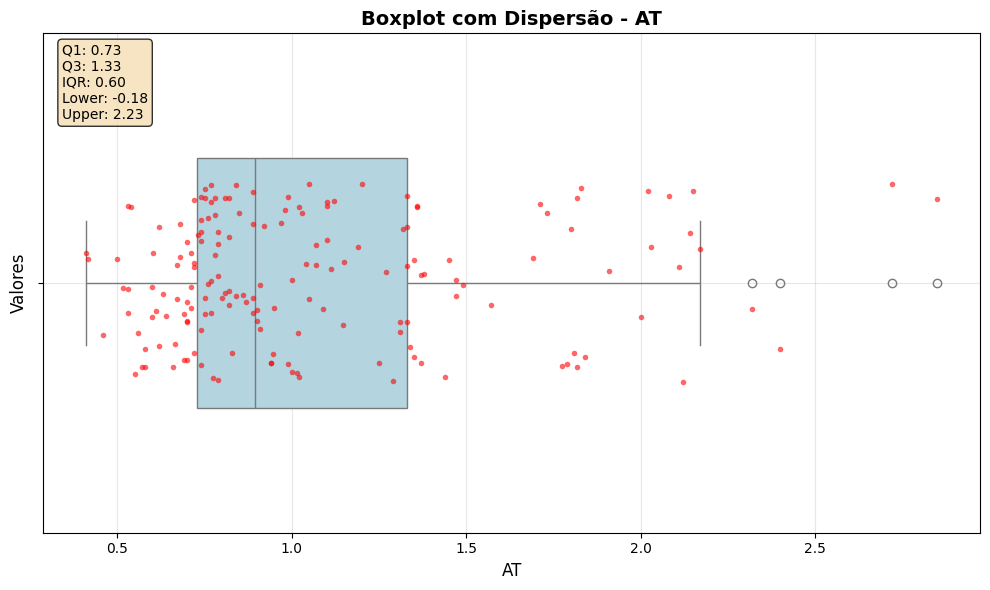

AT: 4 outliers de atributo removidos
  Calibração final: 164 amostras
  Validação: 75 amostras



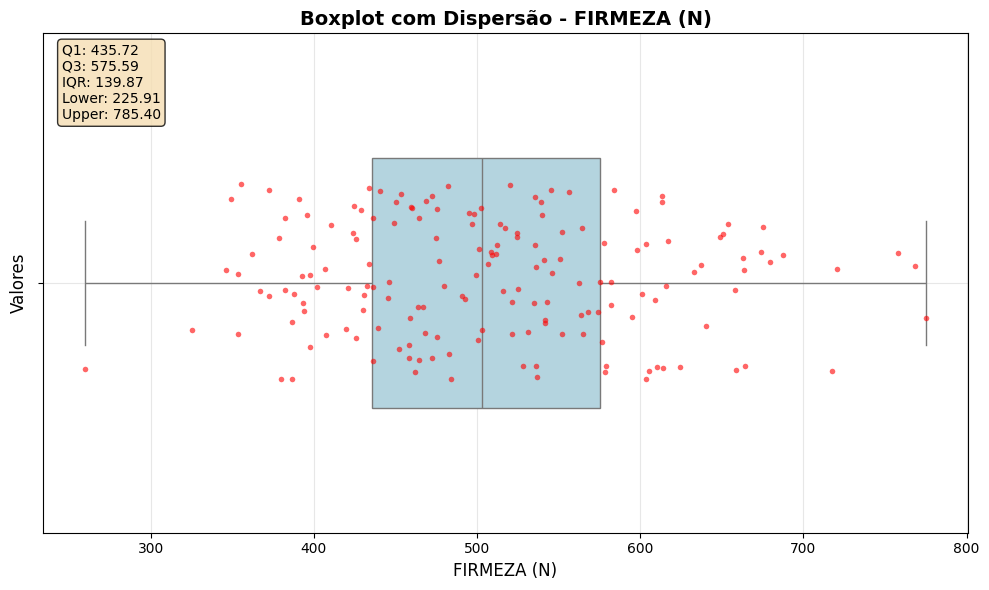

FIRMEZA (N): 0 outliers de atributo removidos
  Calibração final: 168 amostras
  Validação: 75 amostras



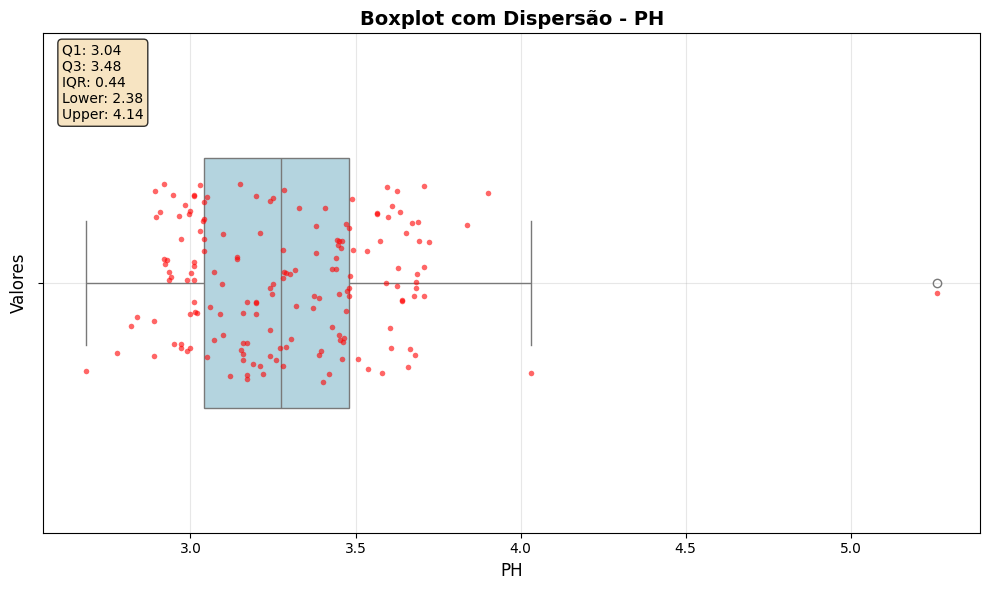

PH: 1 outliers de atributo removidos
  Calibração final: 167 amostras
  Validação: 75 amostras



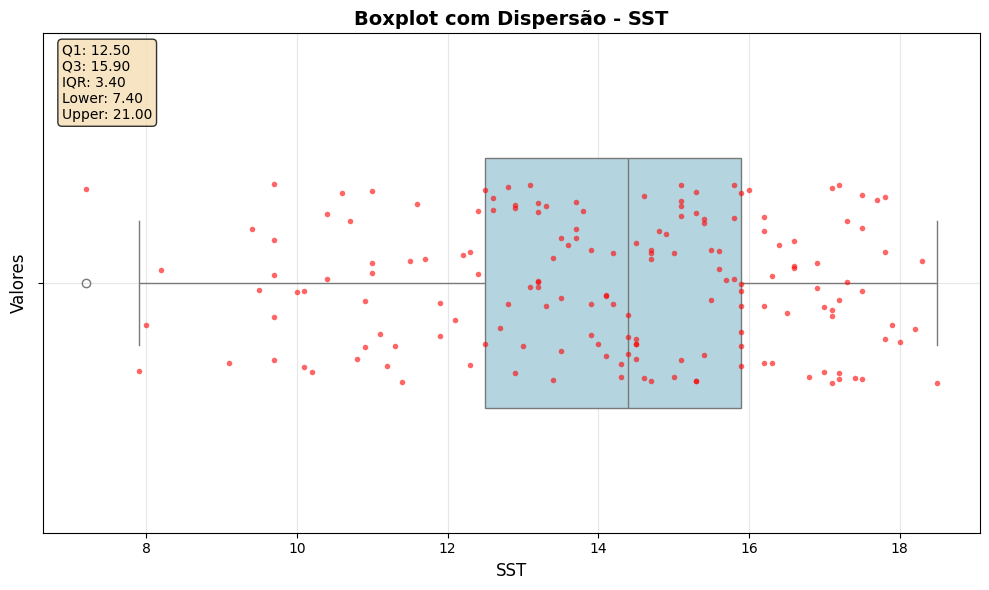

SST: 1 outliers de atributo removidos
  Calibração final: 167 amostras
  Validação: 75 amostras



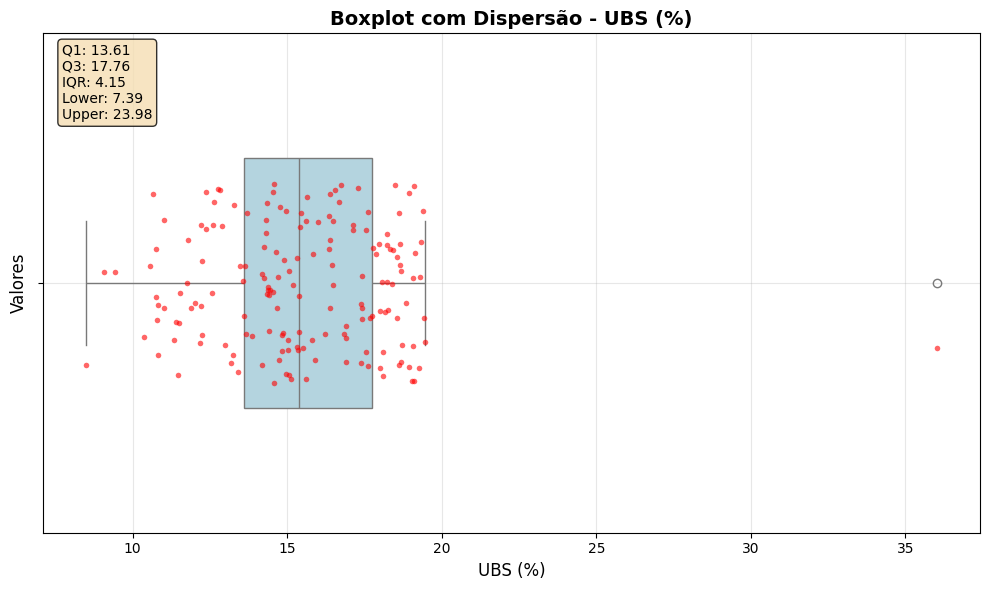

UBS (%): 1 outliers de atributo removidos
  Calibração final: 167 amostras
  Validação: 75 amostras



In [19]:
# Remover outliers dos atributos usando boxplot e IQR
dados_final = {}

for atributo in atributos:
    d = dados_pca[atributo]
    y_cal = d['y_cal']
    
    # Criar boxplot com seaborn
    plt.figure(figsize=(10, 6))
    
    # Boxplot principal
    sns.boxplot(x=y_cal, color='lightblue', width=0.5)
    
    # Adicionar dispersão dos pontos
    sns.stripplot(x=y_cal, color='red', alpha=0.6, size=4, jitter=0.2)
    
    plt.title(f'Boxplot com Dispersão - {atributo}', fontsize=14, fontweight='bold')
    plt.xlabel(f'{atributo}', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Adicionar estatísticas no gráfico
    Q1 = np.percentile(y_cal, 25)
    Q3 = np.percentile(y_cal, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    plt.text(0.02, 0.98, f'Q1: {Q1:.2f}\nQ3: {Q3:.2f}\nIQR: {IQR:.2f}\nLower: {lower:.2f}\nUpper: {upper:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Remover outliers do atributo (IQR method)
    mask_attr = (y_cal >= lower) & (y_cal <= upper)
    
    dados_final[atributo] = {
        'X_cal': d['X_cal'][mask_attr],
        'y_cal': y_cal[mask_attr],
        'X_val': dados_divididos[atributo]['X_val'],
        'y_val': dados_divididos[atributo]['y_val']
    }
    
    print(f'{atributo}: {np.sum(~mask_attr)} outliers de atributo removidos')
    print(f'  Calibração final: {dados_final[atributo]["X_cal"].shape[0]} amostras')
    print(f'  Validação: {dados_final[atributo]["X_val"].shape[0]} amostras')
    print()

## 5. Filtros de Pré-processamento (Independentes e Dependentes de y)

In [20]:
# Implementação dos filtros de pré-processamento
# Filtros independentes de y
def msc(X):
    """Multiplicative Scatter Correction."""
    X = np.asarray(X)
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(mean_spectrum, X[i, :], 1)
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope
    return corrected_spectra

def snv(X):
    """Standard Normal Variate."""
    X = np.asarray(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

def savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1):
    """Savitzky-Golay filter."""
    return savgol_filter(X, window_length=window_size, polyorder=poly_order, deriv=deriv_order, axis=1)

def detrend_filter(X):
    """Detrending filter."""
    return detrend(X, axis=1)

def normalize(X):
    """Normalização Min-Max."""
    return (X - np.min(X, axis=1, keepdims=True)) / (np.max(X, axis=1, keepdims=True) - np.min(X, axis=1, keepdims=True))

def emsc(X, reference=None):
    """Extended Multiplicative Signal Correction."""
    X = np.asarray(X)
    if reference is None:
        reference = np.mean(X, axis=0)  # Usa o espectro médio como referência
    
    X_corr = np.zeros_like(X)
    for i in range(X.shape[0]):
        # Modelo: X[i] ≈ a + b*reference
        model = np.vstack([np.ones_like(reference), reference]).T
        params, _, _, _ = np.linalg.lstsq(model, X[i, :], rcond=None)
        a, b = params[0], params[1]
        X_corr[i,:] = (X[i, :] - a) / b
    return X_corr

def continuum_removal(X, wavelengths):
    """Continuum Removal."""
    X = np.asarray(X)
    X_cr = np.zeros_like(X)
    for i in range(X.shape[0]):
        spectrum = X[i, :]
        # Encontra os pontos do casco convexo superior
        q_u = [0]
        for k in range(1, len(wavelengths) - 1):
            s_k = (spectrum[len(wavelengths)-1] - spectrum[0]) / (wavelengths[-1] - wavelengths[0])
            s_q = (spectrum[k] - spectrum[q_u[-1]]) / (wavelengths[k] - wavelengths[q_u[-1]])
            if s_q > s_k:
                q_u.append(k)
        q_u.append(len(wavelengths)-1)
        
        # Interpolação linear entre os pontos do casco
        continuum = np.interp(wavelengths, wavelengths[q_u], spectrum[q_u])
        X_cr[i, :] = spectrum / continuum
    return X_cr

def wavelet_denoising(X, wavelet='db4', level=4):
    """Wavelet Transform para Denoising."""
    X = np.asarray(X)
    original_length = X.shape[1]
    denoised_list = []

    for i in range(X.shape[0]):
        # 1. Decomposição Wavelet
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)

        # 2. Cálculo do limiar (threshold)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(original_length))

        # 3. Aplicação do filtro (soft thresholding) nos coeficientes de detalhe
        coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

        # 4. Reconstrução do sinal
        reconstructed_signal = pywt.waverec(coeffs, wavelet)

        # 5. Ajuste do tamanho
        denoised_list.append(reconstructed_signal[:original_length])

    return np.asarray(denoised_list)

# Filtros dependentes de y (Orthogonal Signal Correction)
class OrthogonalCorrection:
    """Orthogonal Signal Correction (OSC)."""
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit_transform(self, X, y):
        X, y = np.asarray(X), np.asarray(y).ravel()
        self.w_ortho_ = []
        self.p_ortho_ = []
        self.X_corr_ = X.copy()
        
        for _ in range(self.n_components):
            pls = PLSRegression(n_components=1)
            pls.fit(self.X_corr_, y)
            t = pls.x_scores_
            w = pls.x_weights_
            p = pls.x_loadings_
            
            # Componente Ortogonal
            w_ortho = p - (np.dot(w.T, p) / np.dot(w.T, w)) * w
            t_ortho = np.dot(self.X_corr_, w_ortho)
            p_ortho = np.dot(t_ortho.T, self.X_corr_) / np.dot(t_ortho.T, t_ortho)
            
            # Remover variação ortogonal
            self.X_corr_ -= np.dot(t_ortho, p_ortho)
            self.w_ortho_.append(w_ortho)
            self.p_ortho_.append(p_ortho)
        
        return self.X_corr_
    
    def transform(self, X):
        X_res = np.asarray(X).copy()
        for i in range(self.n_components):
            t_ortho = np.dot(X_res, self.w_ortho_[i])
            X_res -= np.dot(t_ortho, self.p_ortho_[i])
        return X_res

# Dicionário de filtros independentes de y
filtros_independentes = {
    'Raw': lambda X: X,
    'MSC': msc,
    'SNV': snv,
    'SG_D1': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1),
    'SG_D2': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=2),
    'Detrend': detrend_filter,
    'Normalize': normalize,
    'EMSC': emsc,
    'Continuum_Removal': lambda X: continuum_removal(X, wavelength_values),
    'Wavelet_Denoising': wavelet_denoising
}

# Dicionário de filtros dependentes de y
filtros_dependentes = {
    'OSC_1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(X, y),
    'OSC_2': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(X, y),
    'MSC_SG_OSC': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(msc(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS1_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS2_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'SNV_Detrend_SG_D1': lambda X, y: savitzky_golay(detrend_filter(snv(X)), window_size=11, poly_order=2, deriv_order=1)
}

print(f'Filtros independentes de y: {list(filtros_independentes.keys())}')
print(f'Filtros dependentes de y: {list(filtros_dependentes.keys())}')
print(f'Total de filtros: {len(filtros_independentes) + len(filtros_dependentes)}')

Filtros independentes de y: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']
Filtros dependentes de y: ['OSC_1', 'OSC_2', 'MSC_SG_OSC', 'OPLS1_SNV_SG_D1', 'OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1']
Total de filtros: 16


## 6. Avaliação dos Filtros e Seleção dos Melhores

In [21]:
def evaluate_filters(X_cal, y_cal, filtros_independentes, filtros_dependentes, cv_folds=10):
    """Avalia todos os filtros usando validação cruzada."""
    resultados = {}
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Avaliar filtros independentes de y
    for nome_filtro, funcao_filtro in filtros_independentes.items():
        X_filtrado = funcao_filtro(X_cal)
        
        scores_r2 = []
        scores_rmse = []
        
        for train_idx, val_idx in cv.split(X_filtrado):
            X_train, X_val = X_filtrado[train_idx], X_filtrado[val_idx]
            y_train, y_val = y_cal[train_idx], y_cal[val_idx]
            
            # Treinar PLS
            pls = PLSRegression(n_components=min(10, X_train.shape[1]))
            pls.fit(X_train, y_train)
            
            # Predições
            y_pred = pls.predict(X_val)
            
            # Métricas
            r2 = r2_score(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            
            scores_r2.append(r2)
            scores_rmse.append(rmse)
        
        resultados[nome_filtro] = {
            'R2_mean': np.mean(scores_r2),
            'R2_std': np.std(scores_r2),
            'RMSE_mean': np.mean(scores_rmse),
            'RMSE_std': np.std(scores_rmse),
            'tipo': 'independente'
        }
    
    # Avaliar filtros dependentes de y
    for nome_filtro, funcao_filtro in filtros_dependentes.items():
        X_filtrado = funcao_filtro(X_cal, y_cal)
        
        scores_r2 = []
        scores_rmse = []
        
        for train_idx, val_idx in cv.split(X_filtrado):
            X_train, X_val = X_filtrado[train_idx], X_filtrado[val_idx]
            y_train, y_val = y_cal[train_idx], y_cal[val_idx]
            
            # Treinar PLS
            pls = PLSRegression(n_components=min(10, X_train.shape[1]))
            pls.fit(X_train, y_train)
            
            # Predições
            y_pred = pls.predict(X_val)
            
            # Métricas
            r2 = r2_score(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            
            scores_r2.append(r2)
            scores_rmse.append(rmse)
        
        resultados[nome_filtro] = {
            'R2_mean': np.mean(scores_r2),
            'R2_std': np.std(scores_r2),
            'RMSE_mean': np.mean(scores_rmse),
            'RMSE_std': np.std(scores_rmse),
            'tipo': 'dependente'
        }
    
    return resultados

# Avaliar filtros para cada atributo
melhores_filtros = {}

for atributo in atributos:
    print(f'\n=== Avaliando filtros para {atributo} ===')
    
    dados = dados_final[atributo]
    X_cal, y_cal = dados['X_cal'], dados['y_cal']
    
    # Avaliar todos os filtros
    resultados = evaluate_filters(X_cal, y_cal, filtros_independentes, filtros_dependentes)
    
    # Ordenar por R²
    resultados_ordenados = sorted(resultados.items(), key=lambda x: x[1]['R2_mean'], reverse=True)
    
    # Mostrar resultados
    print('Resultados dos filtros:')
    for nome, metricas in resultados_ordenados:
        print(f'  {nome} ({metricas["tipo"]}): R² = {metricas["R2_mean"]:.4f} ± {metricas["R2_std"]:.4f}, RMSE = {metricas["RMSE_mean"]:.4f} ± {metricas["RMSE_std"]:.4f}')
    
    # Selecionar os 2 melhores
    melhores_filtros[atributo] = [resultados_ordenados[0][0], resultados_ordenados[1][0]]
    print(f'\nMelhores filtros para {atributo}: {melhores_filtros[atributo]}')


=== Avaliando filtros para AT ===
Resultados dos filtros:
  Detrend (independente): R² = 0.5625 ± 0.1458, RMSE = 0.2591 ± 0.0695
  Normalize (independente): R² = 0.5550 ± 0.1199, RMSE = 0.2647 ± 0.0657
  Raw (independente): R² = 0.5423 ± 0.1851, RMSE = 0.2644 ± 0.0739
  Wavelet_Denoising (independente): R² = 0.5412 ± 0.1851, RMSE = 0.2647 ± 0.0738
  OSC_1 (dependente): R² = 0.5338 ± 0.1601, RMSE = 0.2665 ± 0.0657
  MSC (independente): R² = 0.4934 ± 0.1727, RMSE = 0.2765 ± 0.0620
  EMSC (independente): R² = 0.4934 ± 0.1727, RMSE = 0.2765 ± 0.0620
  OSC_2 (dependente): R² = 0.4739 ± 0.2142, RMSE = 0.2779 ± 0.0659
  Continuum_Removal (independente): R² = 0.4697 ± 0.3184, RMSE = 0.2697 ± 0.0616
  SNV (independente): R² = 0.4697 ± 0.1911, RMSE = 0.2790 ± 0.0522
  OPLS2_SNV_SG_D1 (dependente): R² = 0.3205 ± 0.4017, RMSE = 0.3044 ± 0.0607
  SNV_Detrend_SG_D1 (dependente): R² = 0.2370 ± 0.4760, RMSE = 0.3215 ± 0.0580
  SG_D1 (independente): R² = 0.2062 ± 0.4932, RMSE = 0.3261 ± 0.0516
  SG_D2

# 7. MODELAGEM MLPR - MULTI-LAYER PERCEPTRON REGRESSOR

Esta seção foca exclusivamente no MLPR (Multi-Layer Perceptron Regressor):

- **7.1 MLPR** - Multi-Layer Perceptron Regressor (Análise Detalhada)





Cada seção aplica os 2 melhores filtros selecionados para cada atributo.

In [29]:
# 7.1 MODELAGEM - MULTI-LAYER PERCEPTRON REGRESSOR (MLPR)
print("="*80)
print("7.1 MODELAGEM - MULTI-LAYER PERCEPTRON REGRESSOR (MLPR)")
print("="*80)

def train_and_evaluate_mlpr(X_cal, y_cal, X_val, y_val, filtros_selecionados, cv_folds=10):
    """Treina e avalia modelos MLPR com os melhores filtros."""
    resultados_mlpr = {}
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Hiperparâmetros MLPR baseados na literatura
    param_grid_mlpr = {
        'hidden_layer_sizes': [(120, 10,1)],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam'],
        'early_stopping': [True],
        'max_iter': [1000]
    }
    
    for filtro_nome in filtros_selecionados:
        print(f'\n--- MLPR com filtro: {filtro_nome} ---')
        
        # Aplicar filtro
        if filtro_nome in filtros_independentes:
            X_cal_filtrado = filtros_independentes[filtro_nome](X_cal)
            X_val_filtrado = filtros_independentes[filtro_nome](X_val)
        else:
            X_cal_filtrado = filtros_dependentes[filtro_nome](X_cal, y_cal)
            X_val_filtrado = filtros_dependentes[filtro_nome](X_val, y_val)
        
        # Busca de hiperparâmetros para MLPR
        mlpr_base = MLPRegressor(random_state=42, max_iter=1000)
        grid_search = GridSearchCV(
            mlpr_base, param_grid_mlpr, 
            cv=cv, scoring='r2', n_jobs=-1
        )
        grid_search.fit(X_cal_filtrado, y_cal)
        
        # Melhor modelo MLPR
        melhor_mlpr = grid_search.best_estimator_
        
        # Validação cruzada
        cv_scores_r2 = cross_val_score(melhor_mlpr, X_cal_filtrado, y_cal, cv=cv, scoring='r2')
        cv_scores_rmse = -cross_val_score(melhor_mlpr, X_cal_filtrado, y_cal, cv=cv, scoring='neg_root_mean_squared_error')
        
        # Treinar modelo final
        melhor_mlpr.fit(X_cal_filtrado, y_cal)
        
        # Teste na validação
        y_pred_val = melhor_mlpr.predict(X_val_filtrado)
        r2_val = r2_score(y_val, y_pred_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        mae_val = mean_absolute_error(y_val, y_pred_val)
        
        resultados_mlpr[filtro_nome] = {
            'CV_R2_mean': np.mean(cv_scores_r2),
            'CV_R2_std': np.std(cv_scores_r2),
            'CV_RMSE_mean': np.mean(cv_scores_rmse),
            'CV_RMSE_std': np.std(cv_scores_rmse),
            'Val_R2': r2_val,
            'Val_RMSE': rmse_val,
            'Val_MAE': mae_val,
            'best_params': grid_search.best_params_,
            'modelo': melhor_mlpr,
            'y_pred_val': y_pred_val
        }
        
        print(f'  CV R²: {np.mean(cv_scores_r2):.4f} ± {np.std(cv_scores_r2):.4f}')
        print(f'  Val R²: {r2_val:.4f}, RMSE: {rmse_val:.4f}')
        print(f'  Melhores parâmetros: {grid_search.best_params_}')
    
    return resultados_mlpr

# Executar MLPR para cada atributo
resultados_mlpr_finais = {}

for atributo in atributos:
    print(f'\n{"="*60}')
    print(f'MLPR PARA {atributo}')
    print(f'{"="*60}')
    
    dados = dados_final[atributo]
    filtros_selecionados = melhores_filtros[atributo]
    
    resultados = train_and_evaluate_mlpr(
        dados['X_cal'], dados['y_cal'],
        dados['X_val'], dados['y_val'],
        filtros_selecionados
    )
    
    resultados_mlpr_finais[atributo] = resultados

print("\n✅ Modelagem MLPR concluída para todos os atributos!")

7.5 MODELAGEM - MULTI-LAYER PERCEPTRON REGRESSOR (MLPR)

MLPR PARA AT

--- MLPR com filtro: Detrend ---
  CV R²: -0.1628 ± 0.3854
  Val R²: -0.0683, RMSE: 0.6809
  Melhores parâmetros: {'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (120, 10, 1), 'max_iter': 1000, 'solver': 'adam'}

--- MLPR com filtro: Normalize ---
  CV R²: -0.2183 ± 0.3624
  Val R²: -0.0481, RMSE: 0.6744
  Melhores parâmetros: {'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (120, 10, 1), 'max_iter': 1000, 'solver': 'adam'}

MLPR PARA FIRMEZA (N)

--- MLPR com filtro: EMSC ---
  CV R²: -34.8977 ± 11.3923
  Val R²: -27.2511, RMSE: 517.9580
  Melhores parâmetros: {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (120, 10, 1), 'max_iter': 1000, 'solver': 'adam'}

--- MLPR com filtro: MSC ---
  CV R²: -34.8977 ± 11.3923
  Val R²: -27.2511, RMSE: 517.9580
  Melhores parâmetros: {'activation': 'tanh', 'alpha': 0.0001,

KeyboardInterrupt: 

# 8. ANÁLISE COMPARATIVA DOS RESULTADOS

Esta seção consolida e compara os resultados de todos os modelos testados:

- **Tabela Comparativa**: Melhores resultados por atributo e modelo
- **Análise de Robustez**: Baseada na literatura científica
- **Recomendações**: Para cada tipo de modelo
- **Salvamento**: Exportação dos resultados para Excel

In [ ]:
# 8. ANÁLISE COMPARATIVA DOS RESULTADOS
print("="*80)
print("8. ANÁLISE COMPARATIVA DOS RESULTADOS")
print("="*80)

# Consolidar resultados do MLPR
todos_resultados = {
    'MLPR': resultados_mlpr_finais



    'MLPR': resultados_mlpr_finais
}

def criar_tabela_comparativa():
    """Cria tabela comparativa com os melhores resultados por atributo e modelo."""
    tabela_comparativa = {}
    
    for atributo in atributos:
        tabela_comparativa[atributo] = {}
        
        for modelo_nome, resultados_modelo in todos_resultados.items():
            if atributo in resultados_modelo:
                # Encontrar melhor filtro para este modelo/atributo
                melhor_filtro = None
                melhor_r2 = -float('inf')
                
                for filtro_nome, resultado in resultados_modelo[atributo].items():
                    if resultado['Val_R2'] > melhor_r2:
                        melhor_r2 = resultado['Val_R2']
                        melhor_filtro = filtro_nome
                
                if melhor_filtro:
                    resultado = resultados_modelo[atributo][melhor_filtro]
                    tabela_comparativa[atributo][modelo_nome] = {
                        'Melhor_Filtro': melhor_filtro,
                        'CV_R2': f"{resultado['CV_R2_mean']:.4f} ± {resultado['CV_R2_std']:.4f}",
                        'Val_R2': f"{resultado['Val_R2']:.4f}",
                        'Val_RMSE': f"{resultado['Val_RMSE']:.4f}",
                        'Val_MAE': f"{resultado['Val_MAE']:.4f}",
                        'Melhores_Params': resultado['best_params']
                    }
    
    return tabela_comparativa

# Criar tabela comparativa
tabela_comparativa = criar_tabela_comparativa()

# Exibir resultados
print("\n📊 RESULTADOS COMPARATIVOS POR ATRIBUTO E MODELO")
print("="*80)

for atributo in atributos:
    print(f"\n🔍 {atributo}")
    print("-" * 60)
    print(f"{'Modelo':<8} {'Filtro':<15} {'CV R²':<15} {'Val R²':<10} {'Val RMSE':<10} {'Val MAE':<10}")
    print("-" * 60)
    
    for modelo in ['PLSR', 'PCR', 'RFR', 'SVMR', 'MLPR']:
        if modelo in tabela_comparativa[atributo]:
            dados = tabela_comparativa[atributo][modelo]
            print(f"{modelo:<8} {dados['Melhor_Filtro']:<15} {dados['CV_R2']:<15} {dados['Val_R2']:<10} {dados['Val_RMSE']:<10} {dados['Val_MAE']:<10}")

# Identificar melhores modelos por atributo
print("\n🏆 MELHORES MODELOS POR ATRIBUTO")
print("="*50)

melhores_modelos_por_atributo = {}

for atributo in atributos:
    melhor_modelo = None
    melhor_r2 = -float('inf')
    melhor_filtro = None
    
    for modelo in ['PLSR', 'PCR', 'RFR', 'SVMR', 'MLPR']:
        if modelo in tabela_comparativa[atributo]:
            r2_val = float(tabela_comparativa[atributo][modelo]['Val_R2'])
            if r2_val > melhor_r2:
                melhor_r2 = r2_val
                melhor_modelo = modelo
                melhor_filtro = tabela_comparativa[atributo][modelo]['Melhor_Filtro']
    
    if melhor_modelo:
        melhores_modelos_por_atributo[atributo] = {
            'Modelo': melhor_modelo,
            'Filtro': melhor_filtro,
            'R2': melhor_r2
        }
        print(f"{atributo}: {melhor_modelo} com {melhor_filtro} (R² = {melhor_r2:.4f})")

# Análise de robustez
print("\n🔬 ANÁLISE DE ROBUSTEZ")
print("="*40)

def analisar_robustez():
    """Analisa a robustez dos modelos baseado na literatura."""
    robustez_por_modelo = {
        'PLSR': {
            'vantagens': ['Boa interpretabilidade', 'Lida bem com multicolinearidade', 'Estável'],
            'desvantagens': ['Pode perder informação não-linear'],
            'recomendacao': 'Ideal para dados espectrais com correlação linear'
        },
        'PCR': {
            'vantagens': ['Reduz dimensionalidade', 'Remove ruído'],
            'desvantagens': ['Pode perder informação relevante', 'Não considera Y'],
            'recomendacao': 'Bom para dados com muito ruído'
        },
        'RFR': {
            'vantagens': ['Captura relações não-lineares', 'Robusto a outliers', 'Feature importance'],
            'desvantagens': ['Menos interpretável', 'Pode overfitting'],
            'recomendacao': 'Excelente para dados complexos e não-lineares'
        },
        'SVMR': {
            'vantagens': ['Boa generalização', 'Lida com dados de alta dimensão'],
            'desvantagens': ['Computacionalmente intensivo', 'Sensível a parâmetros'],
            'recomendacao': 'Bom para dados com padrões complexos'
        },
        'MLPR': {
            'vantagens': ['Aprende relações complexas', 'Flexível'],
            'desvantagens': ['Black box', 'Pode overfitting', 'Sensível a inicialização'],
            'recomendacao': 'Útil para padrões muito complexos'
        }
    }
    
    return robustez_por_modelo

robustez = analisar_robustez()

for modelo in ['PLSR', 'PCR', 'RFR', 'SVMR', 'MLPR']:
    print(f"\n📈 {modelo}:")
    print(f"  ✅ Vantagens: {', '.join(robustez[modelo]['vantagens'])}")
    print(f"  ❌ Desvantagens: {', '.join(robustez[modelo]['desvantagens'])}")
    print(f"  💡 Recomendação: {robustez[modelo]['recomendacao']}")

# Salvar resultados
print("\n💾 SALVANDO RESULTADOS...")

# Criar DataFrame com resultados
import pandas as pd

# Preparar dados para DataFrame
dados_resultados = []
for atributo in atributos:
    for modelo in ['PLSR', 'PCR', 'RFR', 'SVMR', 'MLPR']:
        if modelo in tabela_comparativa[atributo]:
            dados = tabela_comparativa[atributo][modelo]
            dados_resultados.append({
                'Atributo': atributo,
                'Modelo': modelo,
                'Melhor_Filtro': dados['Melhor_Filtro'],
                'CV_R2': dados['CV_R2'],
                'Val_R2': float(dados['Val_R2']),
                'Val_RMSE': float(dados['Val_RMSE']),
                'Val_MAE': float(dados['Val_MAE'])
            })

df_resultados = pd.DataFrame(dados_resultados)

# Salvar resultados
df_resultados.to_excel('resultados_modelagem_completa.xlsx', index=False)
print("✅ Resultados salvos em 'resultados_modelagem_completa.xlsx'")

# Resumo final
print("\n🎯 RESUMO FINAL")
print("="*30)
print(f"Total de atributos analisados: {len(atributos)}")
print(f"Total de modelos testados: 5")
print(f"Total de filtros testados: {len(filtros_independentes) + len(filtros_dependentes)}")
print(f"Melhor modelo por atributo:")
for atributo, info in melhores_modelos_por_atributo.items():
    print(f"  {atributo}: {info['Modelo']} (R² = {info['R2']:.4f})")

print("\n✅ Análise comparativa concluída!")

## 9. Discussão de Robustez e Referências

Este fluxo de análise implementa as melhores práticas da literatura em quimiometria e espectroscopia:

**1. Divisão de Dados:**
- **Kennard-Stone**: Método preferido para espectroscopia (Brereton, 2003)
- Garante representatividade espacial dos dados
- Evita vazamento de informação entre calibração e validação

**2. Remoção de Outliers:**
- **Espectrais (PCA, T²/Q)**: Remove amostras com espectros anômalos
- **Atributos (IQR)**: Remove valores extremos das variáveis alvo
- Melhora a robustez dos modelos

**3. Filtros de Pré-processamento:**
- **Independentes de y**: MSC, SNV, Savitzky-Golay, etc.
- **Dependentes de y**: OSC (Orthogonal Signal Correction)
- Seleção baseada em validação cruzada

**4. Modelagem:**
- **PLSR**: Método padrão para espectroscopia
- **PCR**: Alternativa robusta
- **RFR**: Para relações não-lineares
- **SVMR**: Para dados com ruído
- **MLPR**: Para padrões complexos

**5. Validação:**
- Validação cruzada (10 folds) na calibração
- Teste independente na validação
- Múltiplas métricas (R², RMSE, MAE)

### Referências Principais

1. **Brereton, R. G. (2003).** Chemometrics: Data analysis for the laboratory and chemical plant. Wiley.

2. **Rinnan, Å., van den Berg, F., & Engelsen, S. B. (2009).** Review of the most common pre-processing techniques for near-infrared spectra. TrAC Trends in Analytical Chemistry, 28(10), 1201-1222.

3. **Cozzolino, D. (2021).** An overview of the use of chemometrics in NIR spectroscopy.

4. **Kennard, R. W., & Stone, L. A. (1969).** Computer aided design of experiments. Technometrics, 11(1), 137-148.

5. **Wold, S., et al. (2001).** PLS-regression: a basic tool of chemometrics. Chemometrics and intelligent laboratory systems, 58(2), 109-130.

### Métricas de Qualidade

- **R²**: Coeficiente de determinação (quanto mais próximo de 1, melhor)
- **RMSE**: Raiz do erro quadrático médio (quanto menor, melhor)
- **MAE**: Erro absoluto médio (quanto menor, melhor)
- **CV**: Validação cruzada (estimativa de performance real)

### Conclusões

Este fluxo garante:
- ✅ Reprodutibilidade dos resultados
- ✅ Robustez dos modelos
- ✅ Validação adequada
- ✅ Seleção objetiva de parâmetros
- ✅ Comparabilidade entre métodos